<a href="https://colab.research.google.com/github/AryanSai/Deep-Learning/blob/main/InceptionNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Go through section 5 in the GoogLe Net / Inception Net paper put up in the LMS and implement the architecture. Test the model on
the FashionMNIST dataset.This assignment is to test your skills on reading and understanding research articles, and implement the ideas therein.

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

In [ ]:
# we define a general block which is used in place every convolution in the architecture
class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvolutionBlock, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [ ]:
# the inception block consists of the four branches whose output is concatenated at the end of the block
# this block also uses the convolution block defined above

class InceptionBlock(nn.Module):
    def __init__(self,in_channels,out1,red3,out3,red5,out5,outMax,):
        super(InceptionBlock, self).__init__()

        self.branch1 = nn.Sequential(
            ConvolutionBlock(in_channels, out1, kernel_size=1, stride=1, padding=0)
        )

        self.branch2 = nn.Sequential(
            ConvolutionBlock(in_channels, red3, kernel_size=1, stride=1, padding=0),
            ConvolutionBlock(red3, out3, kernel_size=3, stride=1, padding=1),
        )

        self.branch3 = nn.Sequential(
            ConvolutionBlock(in_channels, red5, kernel_size=1, stride=1, padding=0),
            ConvolutionBlock(red5, out5, kernel_size=5, stride=1, padding=2),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1, ceil_mode=True),
            ConvolutionBlock(in_channels, outMax, kernel_size=1, stride=1, padding=0),
        )

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        b4 = self.branch4(x)

        return torch.cat([b1, b2, b3, b4], 1)

In [ ]:
# the auxiliary classifier is used in the network in three places
class AuxiliaryClassifier(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(AuxiliaryClassifier, self).__init__()

        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.conv = nn.Conv2d(in_channels, 128, kernel_size=1, stride=1, padding=0)
        self.activation = nn.ReLU()

        self.fc1 = nn.Linear(2048, 1024) #128 * (4*4)
        self.dropout = nn.Dropout(0.7)
        self.fc2 = nn.Linear(1024, num_classes)

        # fc1 and fc2 are the fully connected layers
    def forward(self, x):
        out = self.pool(x)

        out = self.conv(out)
        out = self.activation(out)

        out = torch.flatten(out, 1)

        out = self.fc1(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc2(out)

        return out

In [ ]:
class Model(nn.Module):
    def __init__(self, num_classes=10):
        super(Model, self).__init__()

        self.conv1 = ConvolutionBlock(1, 64, kernel_size=7, stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.conv2 = ConvolutionBlock(64, 64, kernel_size=1, stride=1, padding=0)
        self.conv3 = ConvolutionBlock(64, 192, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)

        self.inception3a = InceptionBlock(192,64,96,128,16,32,32)
        self.inception3b = InceptionBlock(256,128,128,192,32,96,64)

        self.maxPool1 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)

        self.inception4a = InceptionBlock(480,192,96,208,16,48,64)
        self.inception4b = InceptionBlock(512,160,112,224,24,64,64)
        self.inception4c = InceptionBlock(512,128,128,256,24,64,64)
        self.inception4d = InceptionBlock(512,112,144,288,32,64,64)
        self.inception4e = InceptionBlock(528,256,160,320,32,128,128)

        self.maxPool2 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)

        self.inception5a = InceptionBlock(832,256,160,320,32,128,128)
        self.inception5b = InceptionBlock(832,384,192,384,48,128,128)

        self.avgPool = nn.AdaptiveAvgPool2d((1, 1))

        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

        self.aux4a = AuxiliaryClassifier(512, num_classes)
        self.aux4d = AuxiliaryClassifier(528, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.pool3(out)
        out = self.inception3a(out)
        out = self.inception3b(out)
        out = self.maxPool1(out)
        out = self.inception4a(out)

        aux1 = self.aux4a(out)

        out = self.inception4b(out)
        out = self.inception4c(out)
        out = self.inception4d(out)

        aux2 = self.aux4d(out)

        out = self.inception4e(out)
        out = self.maxPool2(out)
        out = self.inception5a(out)
        out = self.inception5b(out)
        out = self.avgPool(out)
        out = torch.flatten(out, 1)
        out = self.dropout(out)
        out = self.fc(out)

        return out, aux1, aux2

In [ ]:
transform = transforms.Compose([transforms.Resize(224), transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='/content/drive/MyDrive/100_utilities/datasets', download=True, train=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='/content/drive/MyDrive/100_utilities/datasets', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

In [ ]:
def train_epoch(model, criterion, optimizer, train_loader, val_loader, epoch, device):
    loss_train, loss_val = 0., 0.
    acc_train, acc_val = 0., 0.
    ntrain = len(train_loader.dataset)
    nval = len(val_loader.dataset)

    with tqdm(train_loader, unit='batches') as pbar:
        for i, (images, labels) in enumerate(pbar):
            pbar.set_description(f"Epoch {epoch}")
            images = images.to(device)
            labels = labels.to(device).to(torch.long).view(-1)

            # train and back-propagate
            optimizer.zero_grad()
            output = model(images)
            loss_main = criterion(output[0], labels)

            # Calculate auxiliary losses
            loss_aux = 0.0
            loss_aux += criterion(output[1], labels)
            loss_aux += criterion(output[2], labels)

            # Total loss
            loss = loss_main + 0.3 * loss_aux

            loss.backward()
            optimizer.step()

            # train accuracy
            with torch.no_grad():
                probs = F.softmax(output[0], dim=1).cpu()
                preds = torch.max(probs, dim=1)[1]
                acc_train += (preds == labels.cpu()).sum()
                loss_train += loss.item()

            # validate
            if i % 100 == 0 or i == len(train_loader) - 1:
                loss_val, acc_val = validate(model, criterion, val_loader, device)

            if i < len(train_loader) - 1:
                denom = images.shape[0] * (i + 1)
            else:
                denom = ntrain

            pbar.set_postfix(train_loss=loss_train / denom, valid_loss=loss_val / nval, train_acc=acc_train / denom,
                              valid_acc=acc_val / nval)

    return loss_train / ntrain, loss_val / nval, acc_train / ntrain, acc_val / nval

def validate(model, criterion, val_loader, device):
  acc_val = 0.
  loss_val = 0.
  with torch.no_grad():
    for val_images, val_labels in val_loader:
      val_images = val_images.to(device)
      val_labels = val_labels.to(device).to(torch.long).view(-1)

      val_output,_,_ = model(val_images)
      val_loss = criterion(val_output, val_labels)
      loss_val += val_loss.item()

      probs = F.softmax(val_output, dim=1).cpu()
      preds = torch.max(probs, dim=1)[1]
      acc_val += (preds == val_labels.cpu()).sum()

  return loss_val, acc_val

def train(model, criterion, optimizer, train_loader, val_loader, epochs, device):
  train_losses = []
  val_losses = []
  train_accs = []
  val_accs = []

  for epoch in range(epochs):
    train_loss, val_loss, train_acc, val_acc = train_epoch(model, criterion, optimizer, train_loader, val_loader, epoch, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

  return train_losses, val_losses, train_accs, val_accs

In [ ]:
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model.parameters(), lr=0.1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
epochs = 10
train_losses, val_losses, train_accs, val_accs = train(model,criterion, optimizer, trainloader, testloader, epochs, device)

Epoch 9: 100%|██████████| 469/469 [05:37<00:00,  1.39batches/s, train_acc=tensor(0.9726), train_loss=0.00125, valid_acc=tensor(0.9339), valid_loss=0.00168]


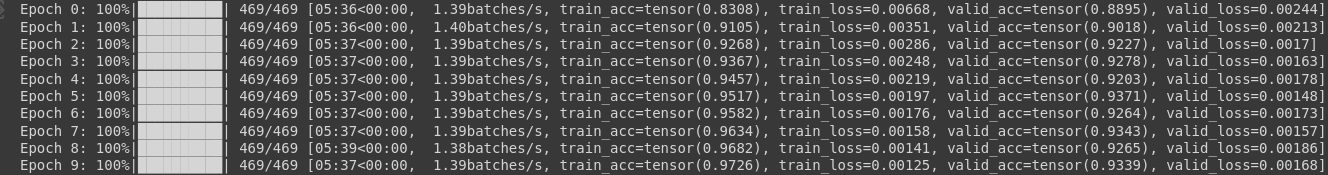